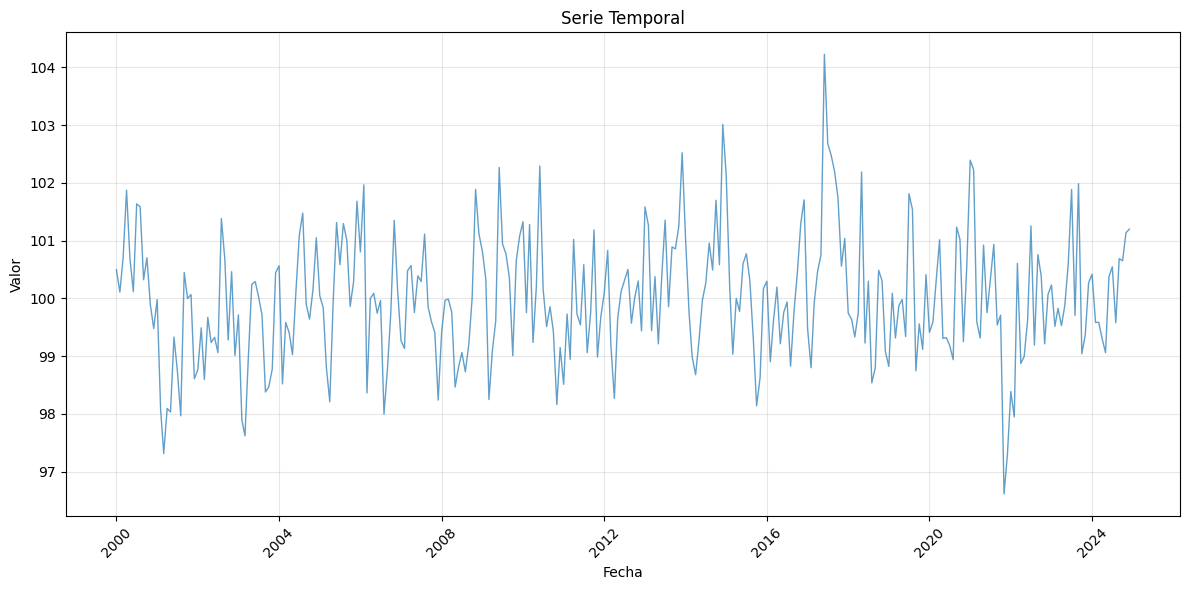

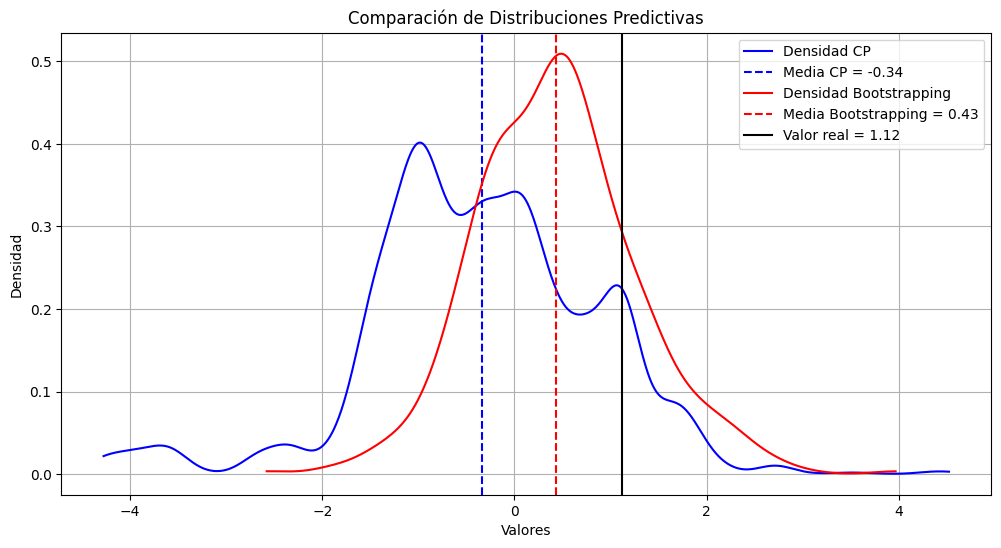


Resultados CRPS por modelo:


,modelo,crps
1,BootstrappingModel,0.434833
0,CPModel,0.902751


In [12]:
import numpy as np
import pandas as pd
from scipy.linalg import solve
from scipy.stats import gaussian_kde
from properscoring import crps_ensemble
from numba import jit
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import warnings

warnings.filterwarnings('ignore')

class ARSimulator:
    """Clase para generar datos simulados usando un proceso AR"""
    def __init__(self, ar_params=[-0.5], ma_params=[1], mean=100, std=1, random_state=42):
        self.ar = np.r_[1, ar_params]
        self.ma = np.array(ma_params)
        self.mean = mean
        self.std = std
        self.random_state = random_state
        
    def generate_data(self, n_points=300, start_date='2000-01-01', freq='MS'):
        np.random.seed(self.random_state)
        arma_process = ArmaProcess(self.ar, self.ma)
        simulated_data = arma_process.generate_sample(nsample=n_points, scale=self.std) + self.mean
        dates = pd.date_range(start=start_date, periods=n_points, freq=freq)
        return pd.DataFrame({'fecha': dates, 'valor': simulated_data})


    
class TimeDistributionModel:
    """Modelo para generar distribuciones predictivas de series temporales"""
    def __init__(self, n_lags=5, rho=0.95, max_points=10000, random_state=42):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.mean_val = None
        self.std_val = None
        self.random_state = random_state
        np.random.seed(self.random_state)
    
    @staticmethod
    @jit(nopython=True)
    def _create_lag_matrix(values, n_lags):
        """Crea matriz de rezagos"""
        n = len(values) - n_lags
        X = np.zeros((n, n_lags + 1))
        X[:, 0] = 1
        
        for lag in range(n_lags):
            X[:, lag + 1] = values[lag:lag + n]
        
        return X
    
    def prepare_data(self, df):
        """Prepara los datos normalizando y creando matrices de rezagos"""
        values = df['valor'].values
        self.mean_val = np.mean(values)
        self.std_val = np.std(values)
        normalized_values = (values - self.mean_val) / self.std_val
        
        X = self._create_lag_matrix(normalized_values, self.n_lags)
        y = normalized_values[self.n_lags:]
        
        return X, y
    
    @staticmethod
    @jit(nopython=True)
    def _fast_hat_matrix(X):
        """Calcula la matriz hat de forma eficiente"""
        XtX = X.T @ X
        XtX_inv = np.linalg.inv(XtX)
        return X @ XtX_inv @ X.T
    
    def calculate_C_values(self, X, y, x_test):
        """Calcula los valores C para la distribución predictiva"""
        n = len(y)
        X_bar = np.vstack((X, x_test))
        H_bar = self._fast_hat_matrix(X_bar)
        H = H_bar[:-1, :-1]
        h = H_bar[-1, :-1]
        
        I_minus_H_inv = solve(np.eye(n) - H, np.eye(n))
        y_minus_Hy = y - H @ y
        h_i_star = H - np.outer(np.ones(n), h)
        
        return y + (h_i_star @ I_minus_H_inv) @ y_minus_Hy
    
    def apply_weights(self, C):
        """Aplica pesos a los valores C"""
        n = len(C)
        weights = self.rho ** np.arange(n-1, -1, -1)
        weights = weights / np.min(weights)
        
        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)
        
        total_points = np.sum(repeats)
        result = np.zeros(total_points)
        
        current_idx = 0
        for i in range(n):
            result[current_idx:current_idx + repeats[i]] = C[i]
            current_idx += repeats[i]
        
        return result
    
    def fit_predict(self, df):
        """Ajusta el modelo y retorna la distribución predictiva"""
        X, y = self.prepare_data(df)
        last_values = (df['valor'].iloc[-self.n_lags-1:-1].values - self.mean_val) / self.std_val
        x_test = np.concatenate(([1], last_values[::-1]))
        y_real = (df['valor'].iloc[-1] - self.mean_val) / self.std_val
        
        C = self.calculate_C_values(X, y, x_test)
        C_weighted = self.apply_weights(C)
        
        return C_weighted, y_real
    
    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva"""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]

class BootstrappingModel:
    """Modelo para generar distribuciones predictivas usando bootstrapping"""
    def __init__(self, n_lags=5, random_state=42):
        self.n_lags = n_lags
        self.random_state = random_state
        self.model = None
        self.mean_val = None
        self.std_val = None
    
    def prepare_data(self, df):
        """Prepara los datos normalizando"""
        values = df['valor'].values
        self.mean_val = np.mean(values)
        self.std_val = np.std(values)
        return (values - self.mean_val) / self.std_val
    
    def fit_predict(self, df, n_boot=500):
        """Ajusta el modelo y genera predicciones bootstrap"""
        normalized_values = self.prepare_data(df)
        
        # Ajustar modelo AutoReg
        self.model = AutoReg(normalized_values, lags=self.n_lags)
        fitted_model = self.model.fit()
        
        # Generar predicciones bootstrap
        predictions = fitted_model.forecast(steps=1)
        residuals = fitted_model.resid
        
        boot_predictions = np.full(n_boot, np.nan)
        rng = np.random.default_rng(seed=self.random_state)
        
        for i in range(n_boot):
            sample_residuals = rng.choice(residuals, size=1, replace=True)
            boot_predictions[i] = predictions + sample_residuals
            
        y_real = normalized_values[-1]
        return boot_predictions, y_real

    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva"""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]

class PlotUtils:
    """Utilidades para visualización de resultados"""
    def __init__(self, random_state=42):
        self.random_state = random_state
        np.random.seed(self.random_state)
    
    @staticmethod
    def plot_time_series(df):
        """Grafica la serie temporal"""
        plt.figure(figsize=(12, 6))
        plt.plot(df['fecha'], df['valor'], alpha=0.7, linewidth=1)
        plt.xlabel('Fecha')
        plt.ylabel('Valor')
        plt.title('Serie Temporal')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_comparative_density(self, distributions_dict, y_real):
        """Grafica la densidad de múltiples distribuciones"""
        plt.figure(figsize=(12, 6))
        colors = ['blue', 'red', 'green', 'purple']
        
        for (name, dist), color in zip(distributions_dict.items(), colors):
            density = gaussian_kde(dist)
            x_vals = np.linspace(min(dist), max(dist), 1000)
            y_vals = density(x_vals)
            mean_dist = np.mean(dist)
            
            plt.plot(x_vals, y_vals, color=color, label=f'Densidad {name}')
            plt.axvline(mean_dist, color=color, linestyle='--',
                       label=f'Media {name} = {mean_dist:.2f}')
        
        plt.axvline(y_real, color='black', linestyle='-',
                   label=f'Valor real = {y_real:.2f}')
        plt.xlabel('Valores')
        plt.ylabel('Densidad')
        plt.title('Comparación de Distribuciones Predictivas')
        plt.legend()
        plt.grid(True)
        plt.show()

def main(random_state=42):
    """Función principal que ejecuta ambos modelos y genera visualizaciones"""
    np.random.seed(random_state)
    
    # Crear datos simulados
    simulator = ARSimulator(random_state=random_state)
    df = simulator.generate_data()
    
    # Crear y ajustar el modelo TimeDistributionModel
    model_td = TimeDistributionModel(random_state=random_state)
    distribution_td, y_real = model_td.fit_predict(df)
    crps_td = model_td.calculate_crps(distribution_td, y_real)
    
    # Crear y ajustar el modelo BootstrappingModel
    model_boot = BootstrappingModel(random_state=random_state)
    distribution_boot, y_real_boot = model_boot.fit_predict(df)
    crps_boot = model_boot.calculate_crps(distribution_boot, y_real_boot)
    
    # Generar visualizaciones
    plot_utils = PlotUtils(random_state=random_state)
    
    # 1. Graficar serie temporal
    plot_utils.plot_time_series(df)
    
    # 2. Graficar densidades comparativas
    distributions_dict = {
        'CP': distribution_td,
        'Bootstrapping': distribution_boot
    }
    plot_utils.plot_comparative_density(distributions_dict, y_real)
    
    # 3. Crear DataFrame con resultados
    results = pd.DataFrame({
        'modelo': ['CPModel', 'BootstrappingModel'],
        'crps': [crps_td, crps_boot]
    })
    
    print("\nResultados CRPS por modelo:")
    # organiza los resultados de menor a mayor
    results = results.sort_values(by='crps')
    display(results)
    
    return results

if __name__ == "__main__":
    results = main(random_state=42)